Let's create a bigram character level language model for subreddit names.
This comes at a challenging time when Reddit is [changing the terms of its API](https://techcrunch.com/2023/07/04/reddit-braces-for-life-after-api-changes/) making most third party apps infeasible (and data extracts like this analysis relies on prohibitively expensive).
However the Reddit community has been an interesting place and understanding the types of communities that are on there is a valuable challenge, especially as many are likely to migrate to different platforms.

This loosely follows part 1 of Andrej Karpathy's excellent [makemore](https://github.com/karpathy/makemore); go and check that out first.
However he used a list of US names, where we're going to use subreddit names.
Here we're going to use a bigram character model; that is predicting each character based on the previous character alone (a classical Markov Model).

::: {.callout-note}
This is a Jupyter notebook you can [download the notebook](https://github.com/EdwardJRoss/skeptric/blob/master/makemore-subreddits-part-1-bigram-model/index.ipynb) or [view it on Kaggle](https://www.kaggle.com/code/edwardjross/makemore-subreddits-part-1-bigram-model).
:::

# Loading the Data

In [42]:
import matplotlib.pyplot as plt
import torch
import csv
from pathlib import Path
from collections import Counter
from tqdm.auto import trange, tqdm

We will load a list of subreddits from the dataset [All Subreddits and Relations Between Them](https://www.kaggle.com/datasets/thedevastator/all-subreddits-and-relations-between-them).

Eash row contains:

* `name` of the subreddit (which corresponds to the url `/r/name`)
* `type` (e.g. banned, public, restricted)
* `title` of the subreddit
* `description` a human readable description
* `subscribers` the number of users subscribed to the subreddit
* `nsfw` whether it is Not Safe For Work (contains adult content)
* `quarantined` whether it has been Quarantined (contains offensive content, opt-in)
* `color`, `img_banner`, `img_icon`: Attributes of how it is displayed
* `created_at`, `updated_at`: Last creation and update time

In [43]:
data_path = Path('/kaggle/input/all-subreddits-and-relations-between-them')

with open(data_path / 'subreddits.csv', 'r') as f:
    data = list(csv.DictReader(f))

for d in data[:5]:
    print(d)
    
for d in data[-5:]:
    print(d)

{'name': '000000000000o0000000', 'type': 'banned', 'title': '000000000000O0000000', 'description': '000000000000O0000000', 'subscribers': '', 'nsfw': '', 'quarantined': '', 'color': '', 'img_banner': '', 'img_icon': '', 'created_at': '2014-12-22 18:00:49+00', 'updated_at': '2022-09-18 21:24:12.370531+00'}
{'name': '0015', 'type': 'public', 'title': '0015', 'description': '', 'subscribers': '1', 'nsfw': 'f', 'quarantined': 'f', 'color': '', 'img_banner': '', 'img_icon': '', 'created_at': '2022-06-01 12:05:00+00', 'updated_at': '2022-09-18 21:24:18.547475+00'}
{'name': '007readalong', 'type': 'banned', 'title': '007 Book Club reading one novel a month. ', 'description': "An online book club for our favorite double 0 agent, James Bond. Come along and join us for discussion about 007's adventures as we read one of Ian Fleming's novels a month.  ", 'subscribers': '', 'nsfw': '', 'quarantined': '', 'color': '', 'img_banner': '', 'img_icon': '', 'created_at': '2016-12-18 03:51:39+00', 'update

There's a whole heap of subreddits

In [44]:
len(data)

127800

The subreddits each have a number of subscribers; the subreddits with the most subscribers are large generic categories.

In [45]:
for d in sorted(data, key=lambda x: int(x['subscribers'] or 0), reverse=True)[:10]:
    print(d['name'], d['description'], d['subscribers'], sep='; ')

announcements; Official announcements from Reddit, Inc.; 172887664
funny; Welcome to r/Funny, Reddit's largest humour depository.; 42967182
askreddit; r/AskReddit is the place to ask and answer thought-provoking questions.; 37206484
gaming; A subreddit for (almost) anything related to games - video games, board games, card games, etc. (but not sports).; 34285916
aww; Things that make you go AWW! Like puppies, bunnies, babies, and so on...

A place for really cute pictures and videos!; 32086859
music; The musical community of reddit; 30619219
worldnews; A place for major news from around the world, excluding US-internal news.; 29658896
pics; A place for pictures and photographs.; 29327437
movies; The goal of /r/Movies is to provide an inclusive place for discussions and news about films with major releases. Submissions should be for the purpose of informing or initiating a discussion, not just to entertain readers. Read our extensive list of rules for more information on other types of 

The number of subscribers is very long tailed

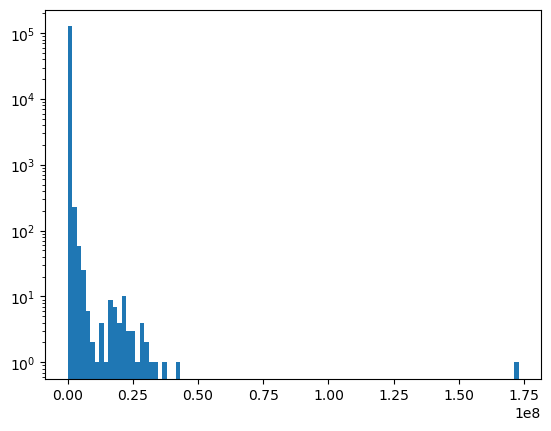

In [46]:
subscribers = [int(d['subscribers'] or 0) for d in data]

plt.hist(subscribers, bins=100, log='y')
None

Let's count the subreddits from largest to smallest.
Again there's a very sharp decline.

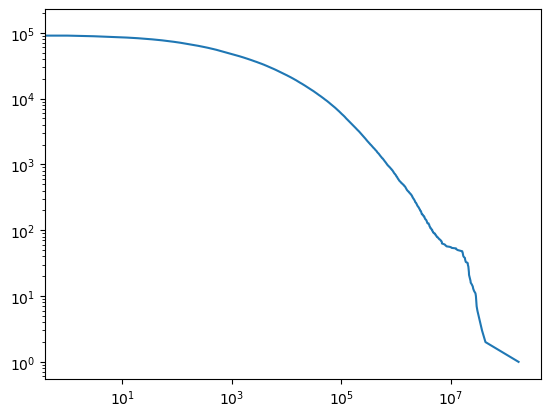

In [47]:
from itertools import accumulate
from operator import add

# {subscriber_count: # of subreddits} in descending order of subscriber_count
subscriber_counts = dict(sorted(Counter(subscribers).items(), reverse=True))
# [cumulative number of subreddits] aligned to subscriber count
subscriber_cumcounts = accumulate(subscriber_counts.values(), add)


# {subscriber_count: # of subreddits}
edf = list(zip(subscriber_counts, subscriber_cumcounts))

plt.plot(*zip(*edf))
plt.xscale('log')
plt.yscale('log')

Let's take the most subscribed subreddits, and aim to get a similar sized dataset to Makemore (32k); reading off the plot this happens a bit over 1,000 subscribers.

In [48]:
min_subscribers = 1_000
len([s for s in subscribers if s >= min_subscribers])

47513

There's a `type`; restricted means not everyone can post to it, and archived means it's older.

In [49]:
Counter(d['type'] for d in data if int(d['subscribers'] or 0) >= min_subscribers)

Counter({'public': 42038, 'restricted': 5458, 'archived': 17})

We'll also exclude nsfw and quarantined subreddits since there's still plenty left.

In [50]:
Counter((d['nsfw'], d['quarantined']) for d in data if int(d['subscribers'] or 0) >= min_subscribers)

Counter({('f', 'f'): 37135, ('t', 'f'): 10365, ('t', 't'): 10, ('f', 't'): 3})

Putting this all together we get our list of subreddits:

* At least 10 subscribers
* Has a description
* Not archived
* SFW and not quarantined

In [51]:
names = [d['name'] for d in data if int(d['subscribers'] or 0) >= min_subscribers
                         and d['description']
                         and d['type'] != 'archived'
                         and d['nsfw'] == 'f'
                         and d['quarantined'] == 'f']
len(names)

33595

The names are mostly human readable

In [52]:
g = torch.Generator().manual_seed(14282386273435573591)

for idx in torch.multinomial(torch.ones(len(names)), 20, generator=g):
    print(names[idx])

amsterdaments
niekmemes
chattanooga
degrowth
singaporefi
cdprojektred
misophonia
monstergirldoctor
weightlifting
facebookwins
allthemods
enkk
sludge
theotown
pirateradio
imaginarycanyons
otoyomegatari
dreampunk
northcascades
pokemongonova


# Summary Statistics of the names

In [53]:
Counter(''.join(names)).most_common()

[('e', 38060),
 ('a', 34082),
 ('i', 28719),
 ('s', 28314),
 ('o', 26156),
 ('r', 26092),
 ('n', 24599),
 ('t', 24343),
 ('l', 17913),
 ('c', 15581),
 ('m', 14049),
 ('d', 13121),
 ('u', 11288),
 ('h', 10840),
 ('g', 10743),
 ('p', 10067),
 ('b', 7585),
 ('y', 6863),
 ('f', 6689),
 ('k', 6190),
 ('w', 4955),
 ('v', 4129),
 ('x', 1560),
 ('_', 1506),
 ('j', 1476),
 ('z', 1045),
 ('q', 458),
 ('2', 436),
 ('0', 389),
 ('1', 352),
 ('4', 296),
 ('3', 249),
 ('5', 136),
 ('6', 131),
 ('9', 118),
 ('8', 93),
 ('7', 65)]

The name lengths have something that resembles a multinomial distribution, containing betwee 2 and 21 characters.

2 21


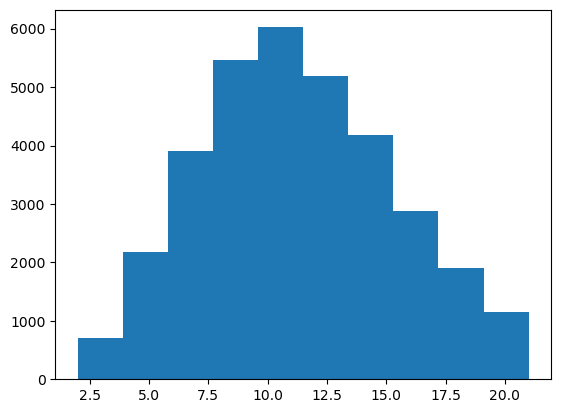

In [54]:
name_lengths = [len(n) for n in names]

print(min(name_lengths), max(name_lengths))

plt.hist(name_lengths)
None

# Counting a bigram model

Even though the subreddit names have casing, the lower cased URL seems to redirect. We end up with the alphabet, `_` and 0-9.

We'll add our own padding character that doesn't occur in the names; `.`

In [55]:
PAD_CHAR = '.'
PAD_IDX = 0

i2s = sorted(set(''.join(names)))
assert PAD_CHAR not in i2s

i2s.insert(PAD_IDX, PAD_CHAR)

print(i2s)

['.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


We can easily build the inverse map from a string to an index

In [56]:
s2i = {s:i for i,s in enumerate(i2s)}

for i in range(len(i2s)):
    assert s2i[i2s[i]] == i
for s in i2s:
    assert i2s[s2i[s]] == s

The total number of characters (including padding) is:

In [57]:
N = len(i2s)
N

38

In [58]:
C = torch.zeros((N,N))

# Counts
for name in names:
    padded_name = PAD_CHAR + name + PAD_CHAR
    for c1, c2 in zip(padded_name, padded_name[1:]):
        C[s2i[c1], s2i[c2]] += 1

A lot of the common 2-grams seem about right for English.

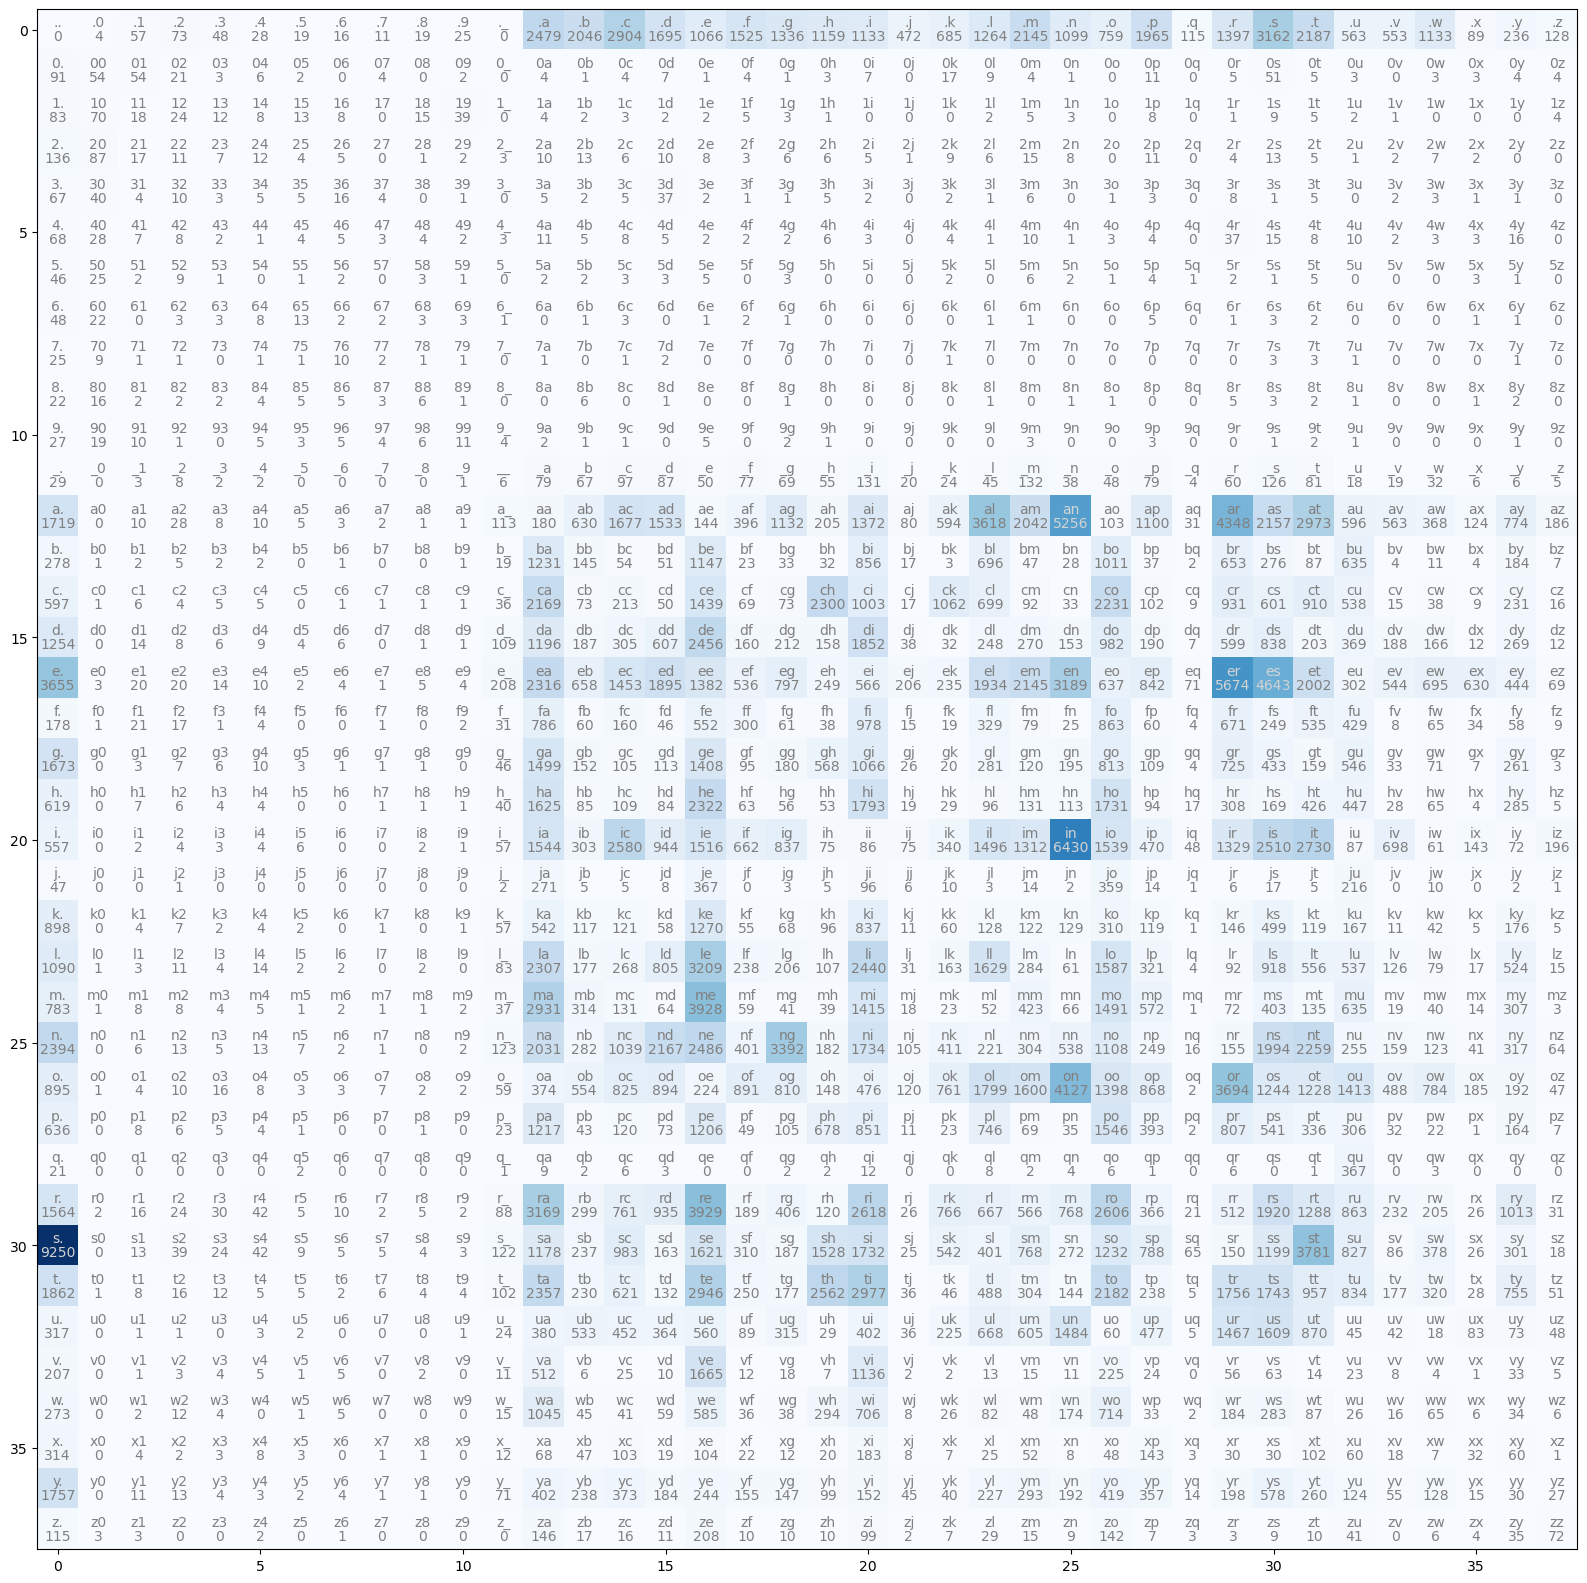

In [59]:
plt.figure(figsize=(20,20))
plt.imshow(C, cmap='Blues')

max_C = C.max().item()
# min_C = 0

for i, s1 in enumerate(i2s):
    for j, s2 in enumerate(i2s):
        string = s1 + s2
        value = int(C[i,j].item())
        # Make sure we can see the text on dark cells
        color = "gray" if value <= 0.5 * max_C else "lightgray"
        
        plt.text(j, i, string, c=color, ha="center", va="bottom")
        plt.text(j, i, value, c=color, ha="center", va="top")

The probabilities (row normalised) also show common English patterns (like q is normally followed by u)

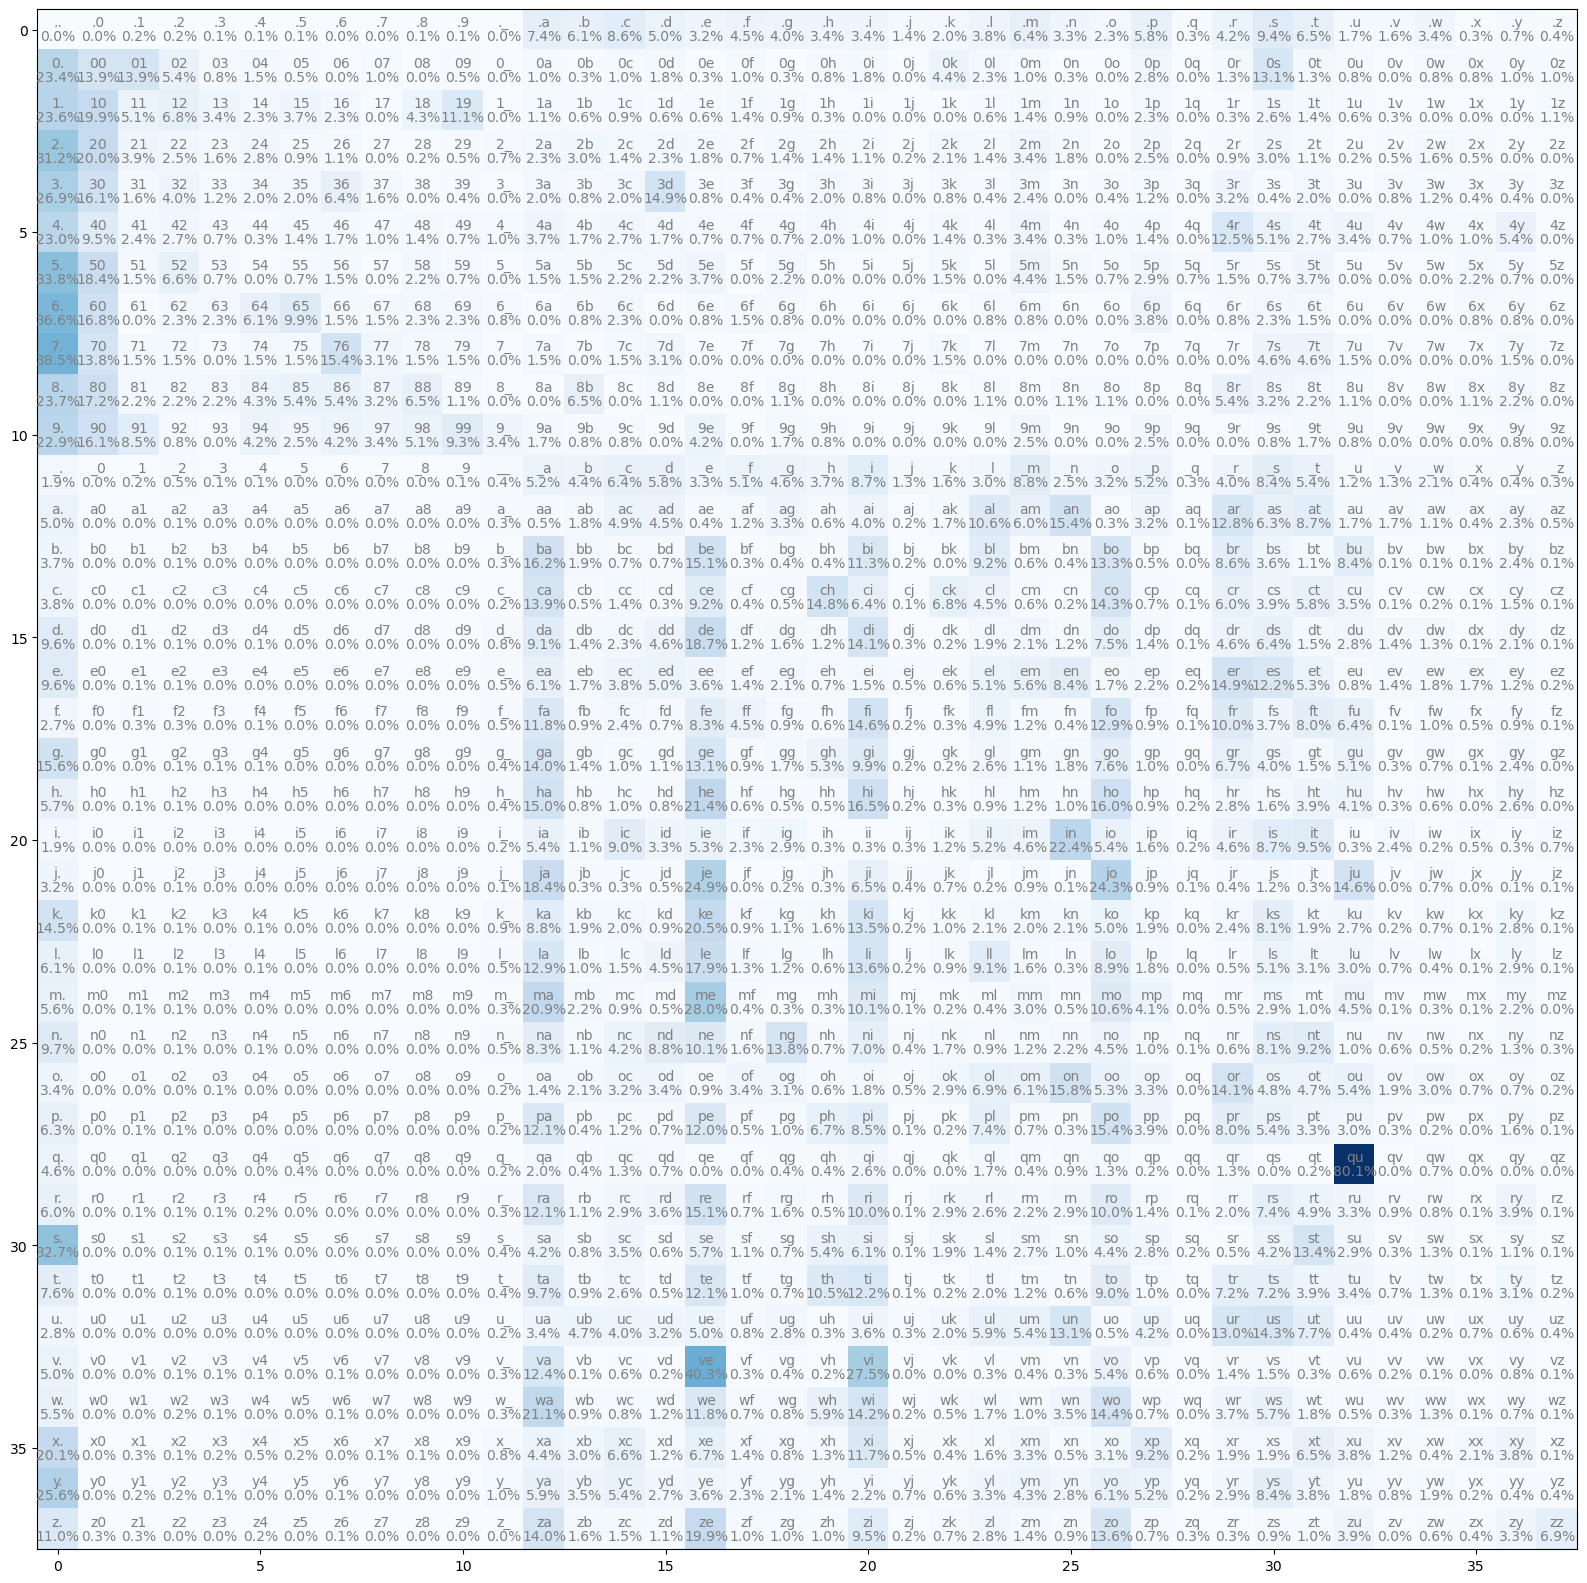

In [60]:
smoothing = 0

P_count = C / (C.sum(axis=1, keepdim=True) + smoothing)

plt.figure(figsize=(20,20))
plt.imshow(P_count, cmap='Blues')

for i, s1 in enumerate(i2s):
    for j, s2 in enumerate(i2s):
        plt.text(j, i, s1+s2, c="gray", ha="center", va="bottom")
        plt.text(j, i, f'{P_count[i,j].item():.1%}', c="gray", ha="center", va="top")

Sampling from the model is slightly better than random, but certainly not plausible subreddit names; we'll need a better model for that.

In [61]:
g = torch.Generator().manual_seed(14282386273435573591)

def sample(P, pad_idx=PAD_IDX, generator=None):
    idx = pad_idx
    output = []

    while True:
        idx = torch.multinomial(P[idx], 1, generator=generator).item()
        if idx == pad_idx:
            break
        output += i2s[idx]
    return ''.join(output)

for _ in range(10):
    print(sample(P_count, generator=g))

tsesencateachoflinonsofeegrsowicoterk
d
jevo
tinditekas
jage
shogpeinposkantes
thunecorgrewshokeisc_e
faba
talshopeanganvaruli
rntstare


We can calculate the Negative Log Likelihood of any name by summing the probabilities for each character.

We can then average it for a name.

In [62]:
def nll1(name, neg_logP, pad_idx=PAD_IDX):
    total = 0
    last_idx = pad_idx
    for c in name:
        idx = s2i[c]
        total += neg_logP[last_idx, idx]
        last_idx = idx
    total += neg_logP[last_idx, pad_idx]
    return total

nll1(names[0], -P_count.log()) / (len(names[0]) + 1)

tensor(3.5824)

Or average it over all names.

In [63]:
sum([nll1(name, -P_count.log()) for name in names]) / sum(len(name) + 1 for name in names)

tensor(2.7334)

Random would assign a 1/N probability for each name.

In [64]:
P_random = torch.ones_like(P_count) / N

sum([nll1(name, -P_random.log()) for name in names]) / sum(len(name) + 1 for name in names)

tensor(3.6377)

And gives an average probability close to 1/N

In [65]:
-torch.tensor(1/N).log()

tensor(3.6376)

# Optimising with Gradient Descent

Count and divide is a very efficient way to optimise multinomial setups like this one, but gradient descent is a much more general way to optimise a much wider class of models.
We'll try to reproduce the result using gradient descent.

To make things more efficient we will represent the dataset as the sequence of prefix indices (X) and suffix indices (y).

In [66]:
X = []
y = []

for name in names:
    padded_name = PAD_CHAR + name + PAD_CHAR
    for c1, c2 in zip(padded_name, padded_name[1:]):
        X.append(s2i[c1])
        y.append(s2i[c2])
        
X, y = torch.tensor(X), torch.tensor(y)
X.shape, y.shape

(torch.Size([412283]), torch.Size([412283]))

The dataset just consists of the names character by character, with y shifted one character ahead of X.

In [67]:
names[:2]

['00srock', '0ad']

In [68]:
for i in range(20):
    print(X[i].item(), y[i].item(), i2s[X[i]], i2s[y[i]], sep='\t')

0	1	.	0
1	1	0	0
1	30	0	s
30	29	s	r
29	26	r	o
26	14	o	c
14	22	c	k
22	0	k	.
0	1	.	0
1	12	0	a
12	15	a	d
15	0	d	.
0	1	.	0
1	30	0	s
30	12	s	a
12	25	a	n
25	20	n	i
20	31	i	t
31	36	t	y
36	24	y	m


With this representation we can quickly calculate the mean negative log likelihood.

In [69]:
-P_count[X, y].log().mean()

tensor(2.7335)

Let's try to learn this matrix using gradient descent.
We start with our weight matrix of logits.

In [70]:
W = torch.randn((N,N), requires_grad=True)

We can calculate the probabilities by exponentiating then row-wise normalising.
The current negative log likelihood is very high - this is very unlikely given the data.

In [71]:
P = W.exp()
P = P / P.sum(axis=1, keepdim=True)


-P[X,y].log().mean()

tensor(4.2383, grad_fn=<NegBackward0>)

We can also calculate the negative log likelihood more efficiently using PyTorch's `cross_entropy` function.

In [72]:
from torch.nn.functional import cross_entropy

loss = cross_entropy(W[X], y)
loss.item()

4.238256454467773

If we take a small step against the direction of the gradient we should decrease the loss.

In [73]:
W.grad = None
loss.backward()

W.data -= 0.1 * W.grad

loss = cross_entropy(W[X], y)
loss.item()

4.237557888031006

How big a step should we take?

Let's use a learning rate finder: exponentially increase the learning rate until it explodes.

Note that the loss is slightly lagging so we don't quite want to pick the minimum point; we pick slightly back from there which is 100.

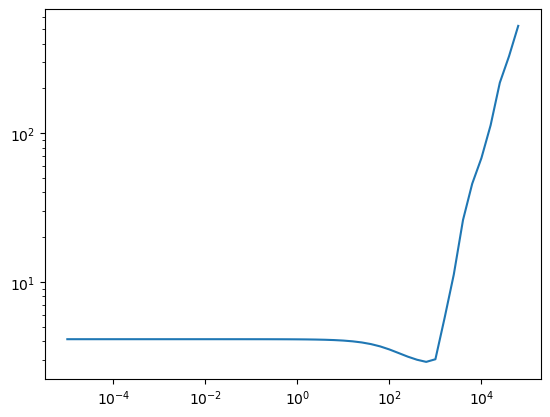

In [74]:
losses = []
W = torch.randn((N,N), requires_grad=True)

lrs = 10**torch.arange(-5, 5, 0.2)

for lr in lrs:
    W.grad = None
    loss = cross_entropy(W[X], y)
    losses.append(loss.item())
    loss.backward()
    W.data -= lr * W.grad
    
plt.plot(lrs, losses)
plt.xscale('log')
plt.yscale('log')

Running it for 2000 steps we get somewhere near the optimum (but not quite there)

  0%|          | 0/2000 [00:00<?, ?it/s]

tensor(2.7342, grad_fn=<NllLossBackward0>)

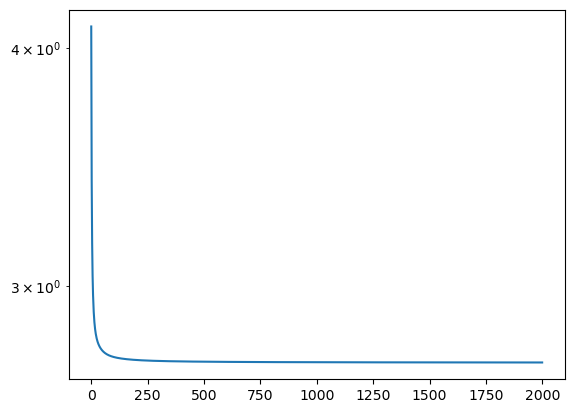

In [75]:
lr = 100

losses = []
grads = []
W = torch.randn((N,N), requires_grad=True)
N_step = 2_000

for step in trange(N_step):
    W.grad = None
    loss = cross_entropy(W[X], y)
    losses.append(loss.item())
    loss.backward()
    grads.append(W.grad.detach())
    W.data -= lr * W.grad
    
plt.plot(losses)
plt.yscale('log')
cross_entropy(W[X], y)

Remember this isn't quite as low a loss as our count and divide model, which is slightly more likely given the data.

In [76]:
-P_count[X, y].log().mean()

tensor(2.7335)

# Analysing the gradient descent model

As with the count model we can analyse the probabilities

In [77]:
P = W.detach().exp()
P = P / P.sum(axis=1, keepdim=True)

And we can generate better than random examples

In [78]:
g = torch.Generator().manual_seed(14282386273435573591)

for _ in range(10):
    print(sample(P, generator=g))

tsesencateachoflinonsofeegrsowicoterk
d
jevo
tinditekas
jage
shogpeinposkantes
thunecorg920shokeisc_e
faba
talshopeanganvaruli
rntstare


And show the distribution of probabilities

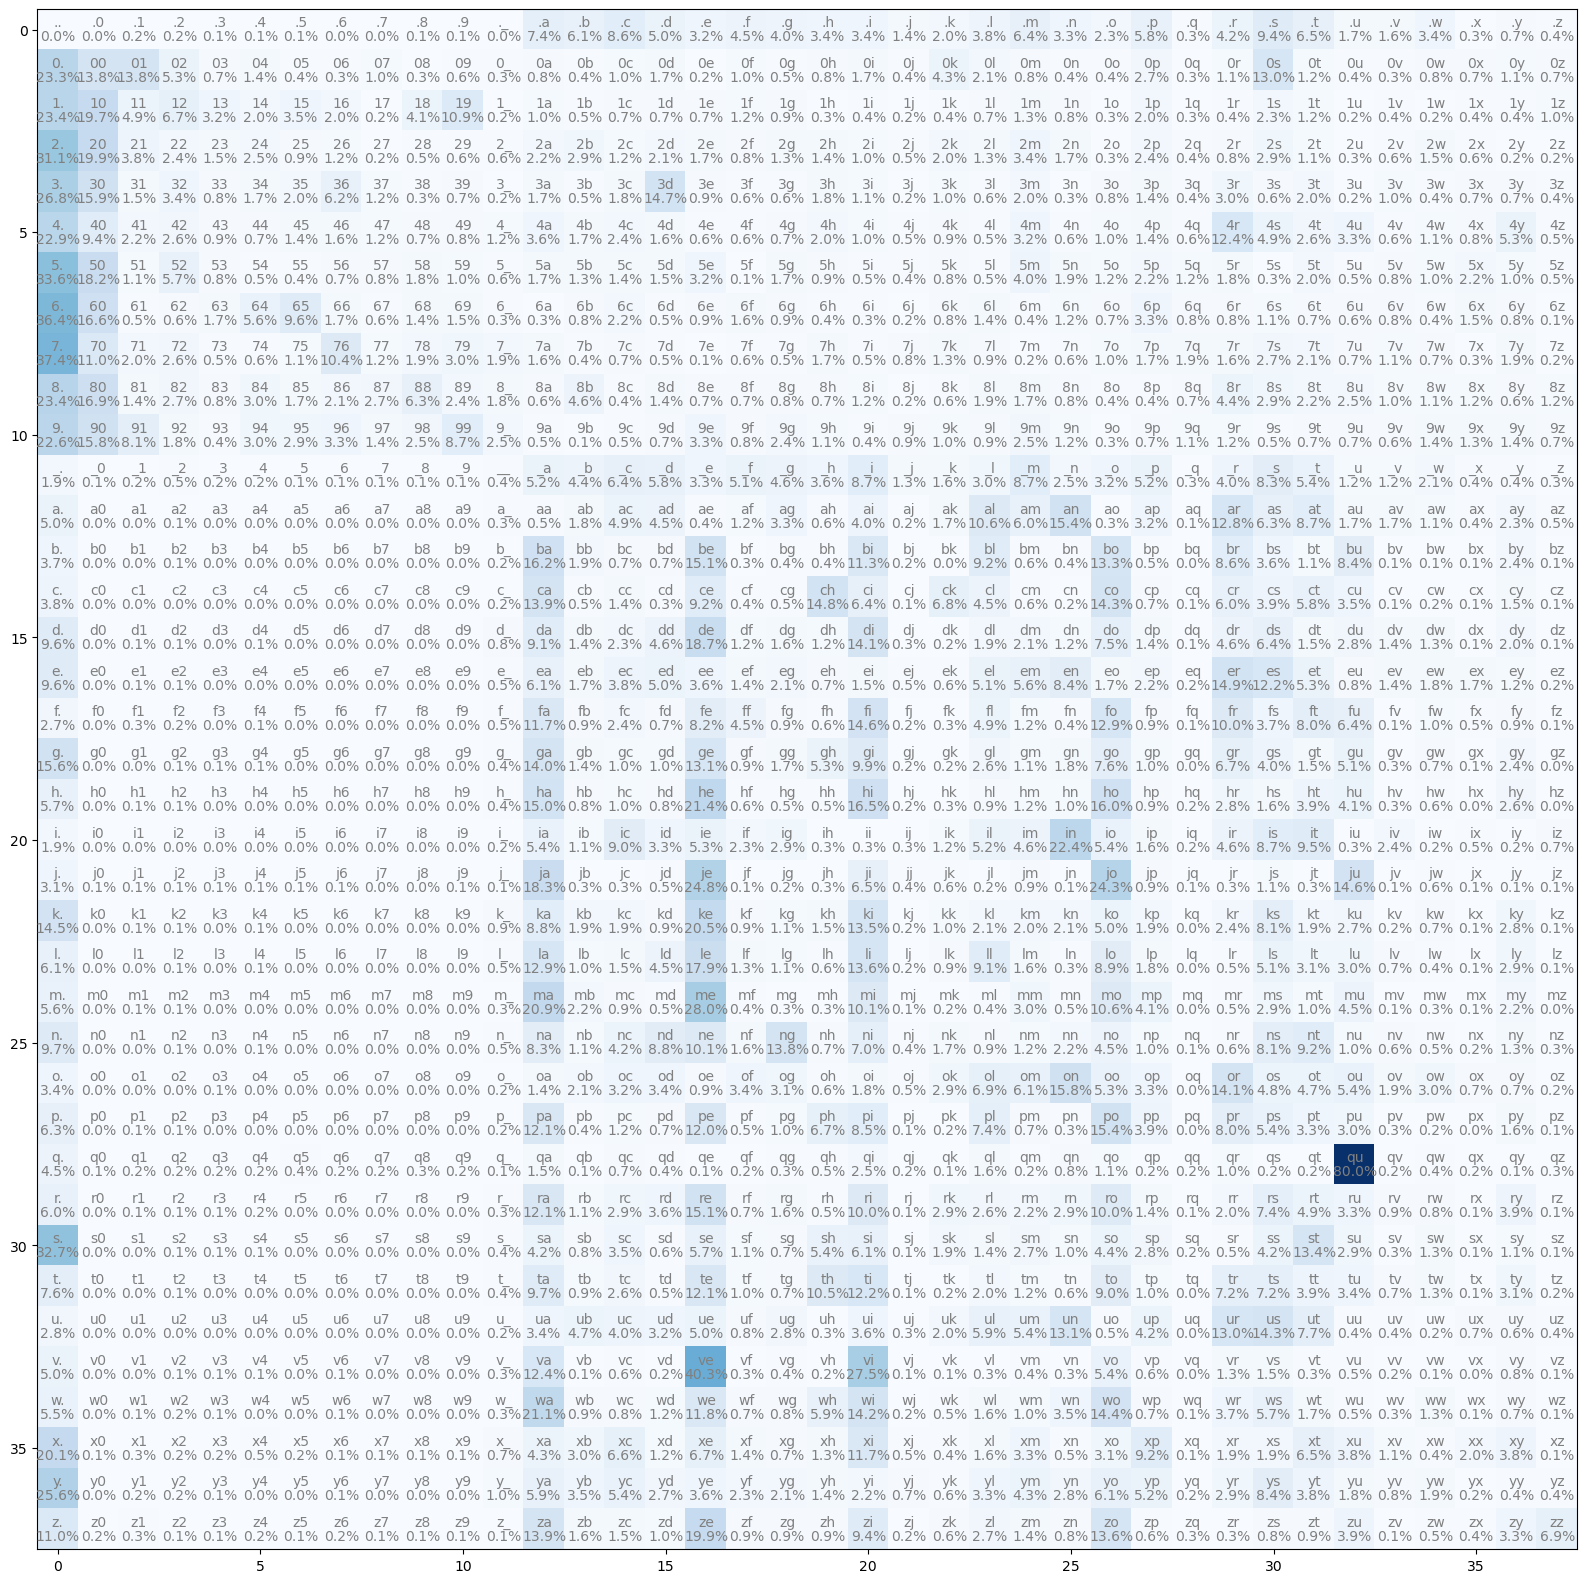

In [79]:
plt.figure(figsize=(20,20))
plt.imshow(P, cmap='Blues')

for i, s1 in enumerate(i2s):
    for j, s2 in enumerate(i2s):
        plt.text(j, i, s1+s2, c="gray", ha="center", va="bottom")
        plt.text(j, i, f'{P[i,j].item():.1%}', c="gray", ha="center", va="top")

We can see that the relative difference between the two is only high where there isn't much data.

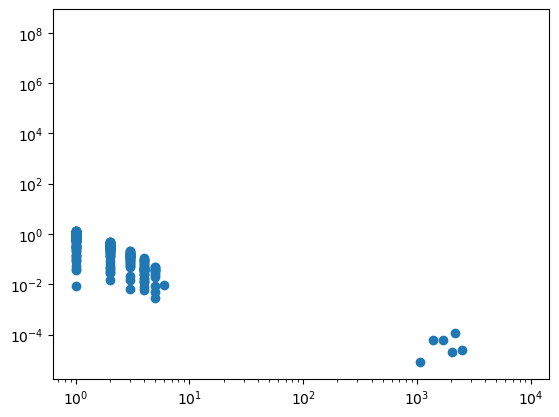

In [80]:
plt.scatter(C.reshape(-1), ((P - P_count) / (P_count+1e-10)).reshape(-1))
plt.xscale('log')
plt.yscale('log')

Another way to see this is to look at the relative difference by bigram.
Infrequent characters such as digits are where there is the biggest difference.

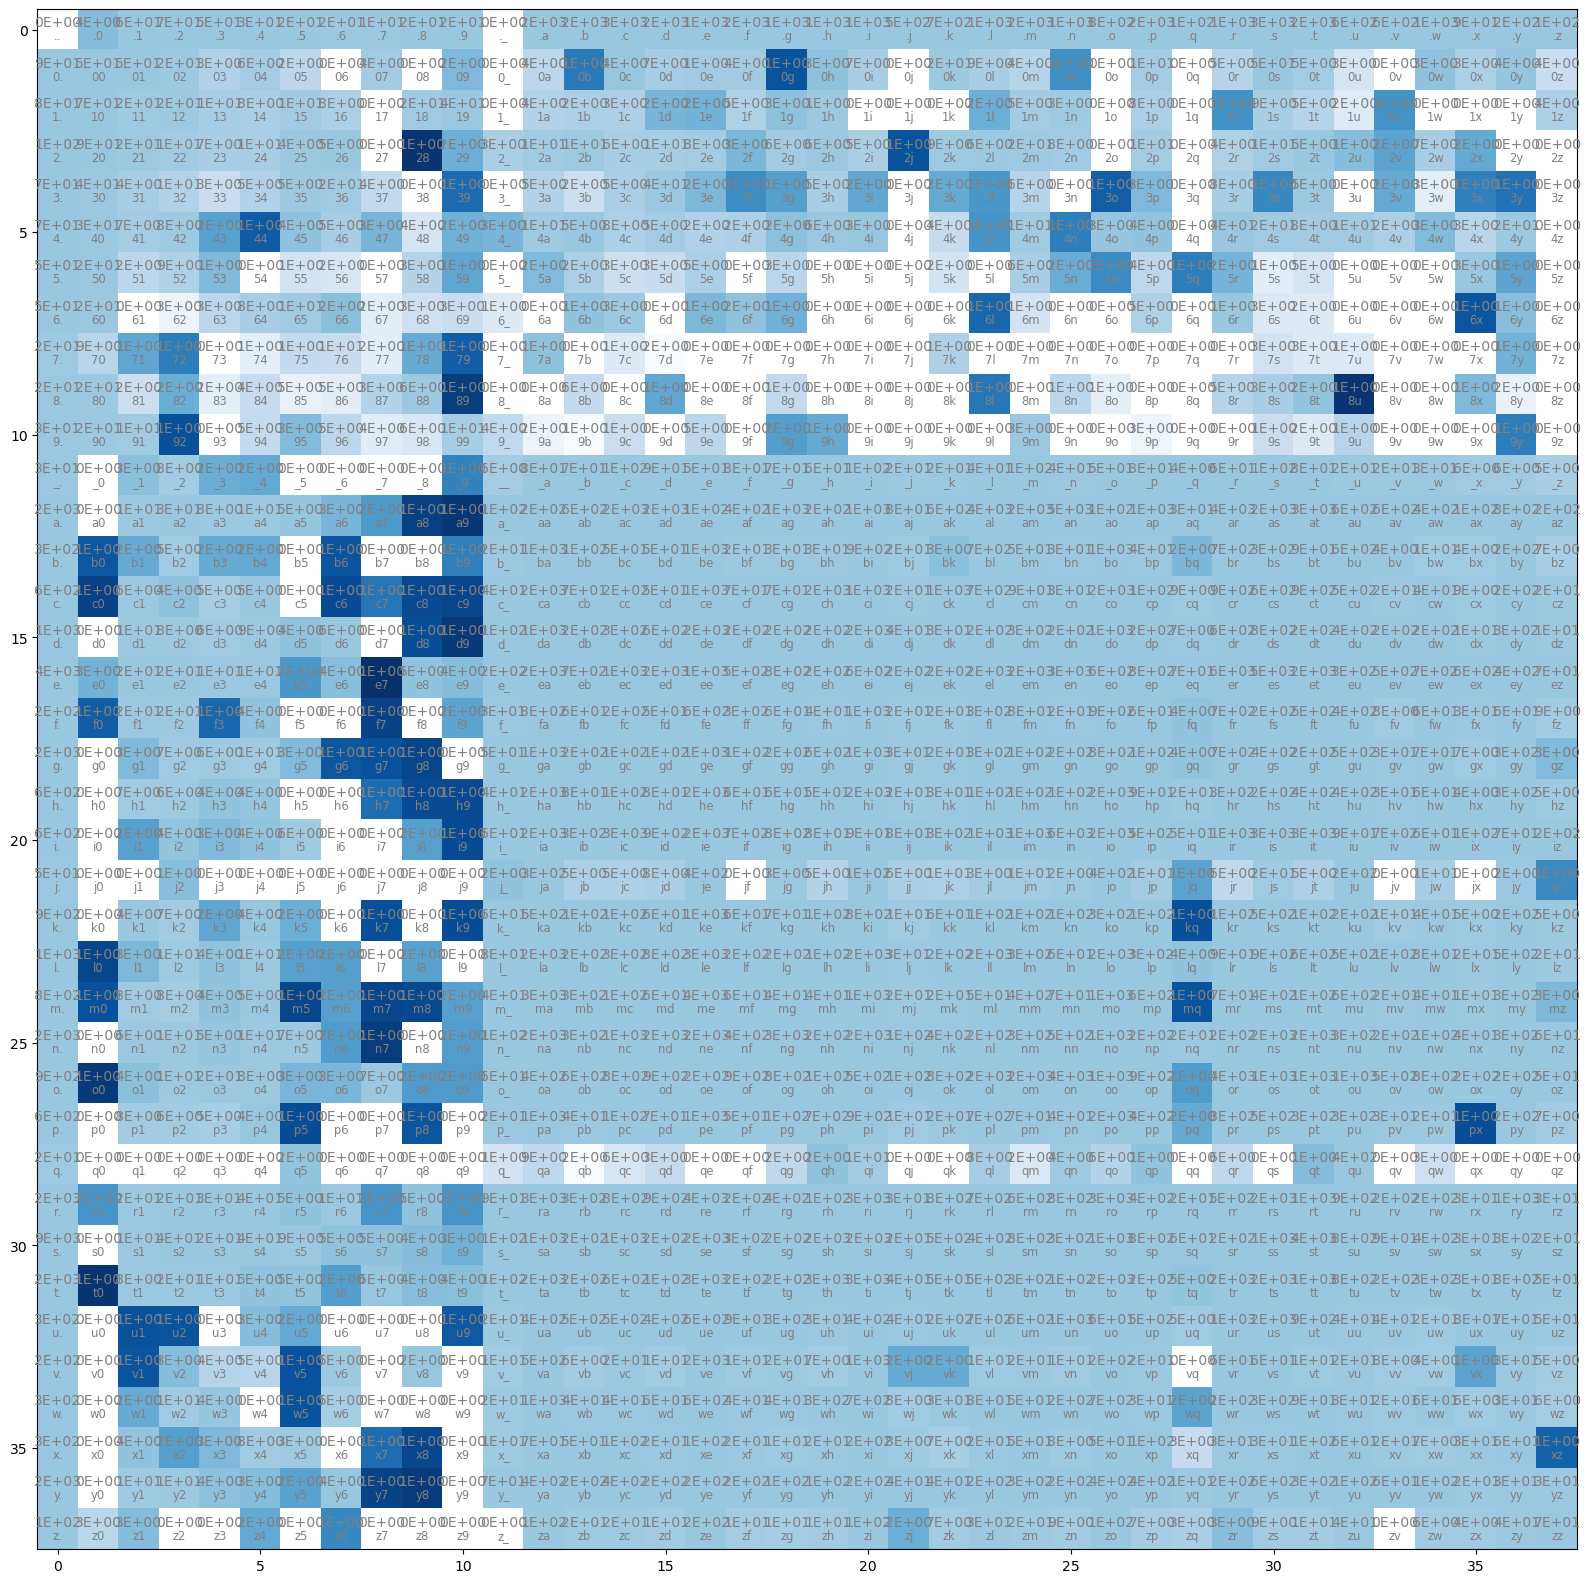

In [81]:
plt.figure(figsize=(20,20))
plt.imshow((P-P_count)/P_count, cmap='Blues')

total = C.sum().item()

for i, s1 in enumerate(i2s):
    for j, s2 in enumerate(i2s):
        plt.text(j, i, s1+s2, c="gray", ha="center", va="top", size="small")
        plt.text(j, i, f'{C[i,j].item():.0E}', c="gray", ha="center", va="bottom")

# How can we do better?

The bigram model is very simple, and n-gram models quickly suffer due to *sparsity*.
With a bit of work and clever regularisation a small n-gram model could do better but the parameters grow exponentially and we need an exponential amount of data.
Instead we can look into dense representation methods.

The other thing to note is our simple gradient descent isn't very efficient, and looking into robust stochastic optimisers would also be worthwhile.